<a href="https://colab.research.google.com/github/vence-andersen/M5-Forecasting-Accuracy/blob/main/EDA_M5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Link for Interactive plot.**

[Click Here](https://nbviewer.jupyter.org/github/vence-andersen/M5-Forecasting-Accuracy/blob/main/Interavtive%20EDA%20File/Interactive_EDA_M5.ipynb) for interactive plot.

# **Removables**

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# ! kaggle competitions download -c m5-forecasting-accuracy

In [4]:
# !unzip sales_train_evaluation.csv.zip
# !unzip sales_train_validation.csv.zip
# !unzip sample_submission.csv.zip
# !unzip sell_prices.csv.zip

In [5]:
# ! pip install downcast
# ! pip install phik
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4

# The below cell contains all modules and libraries required through out the program

In [6]:
# https://github.com/plotly/orca/issues/290#issuecomment-627257795

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from downcast import reduce
import plotly.express as px
from pylab import rcParams
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly
from IPython.display import Image
import sys
import phik
pio.renderers.default = 'svg'
pio.orca.config.use_xvfb = True
# plotly.io.orca.config.executable = '/usr/local/bin/to/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# **Reading all CSV files required and reducing the size as the file sizes are huge**

In [7]:
# Using Pandas to reasd the files.

sales = pd.read_csv("sales_train_evaluation.csv")
sell_price = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

In [8]:
sell_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [9]:
# Reading the file sizes before downcast
a = np.round(sales.memory_usage().sum()/(1024**2),1)
b = np.round(sell_price.memory_usage().sum()/(1024**2),1)
c = np.round(cal.memory_usage().sum()/(1024**2),1)

# Downcating the files. Rewriting on the same variable names reduce creating duplicates and thus saves memory usage.
sales = reduce(sales)
sell_price = reduce(sell_price)
cal = reduce(cal)

# Reading the file sizes after downcast
d = np.round(sales.memory_usage().sum()/(1024**2),1)
e = np.round(sell_price.memory_usage().sum()/(1024**2),1)
f = np.round(cal.memory_usage().sum()/(1024**2),1)

#Displaying the comparision of file size before and after downcasting.
print(f"Size of sales file before downcast was {a} MB and after downcast {d} MB", f"Size of sell_price file before downcast was {b} MB and after downcast {e} MB", \
      f"Size of calender file before downcast was {c} MB and after downcast {f} MB", sep='\n')

Size of sales file before downcast was 452.9 MB and after downcast 96.6 MB
Size of sell_price file before downcast was 208.8 MB and after downcast 45.8 MB
Size of calender file before downcast was 0.2 MB and after downcast 0.1 MB


# Sales EDA

In [10]:
# Displaying the first 2 lines from Sales CSV file
sales.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0


In [11]:
print(f"Observation:\nThere are {sales.isna().sum().sum()} missing/NaN values in sales dataframe")
print(f"""There are {sales['item_id'].nunique()} unique items across {sales['dept_id'].nunique()} 
departments under {sales['cat_id'].nunique()} categories in {sales['state_id'].nunique()} states""")
days = [i for i in sales.columns.values if 'd_' in i]
print(f"There are {len(days)} days columns/features, which is around {len(days)//365} years of data")

Observation:
There are 0 missing/NaN values in sales dataframe
There are 3049 unique items across 7 
departments under 3 categories in 3 states
There are 1941 days columns/features, which is around 5 years of data


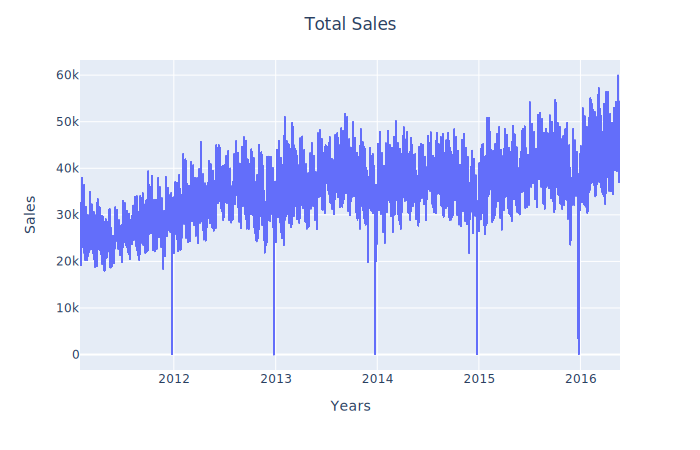

In [12]:
# https://plotly.com/python/time-series/
# https://stackoverflow.com/a/27277074

# Since the Sales CSV has data only for about 1941 days, we are picking the date for 1941 days from Cal CSV.
date = cal.loc[:1940,'date']

# Before plotting the chart for total sales every day across all the states, we are creating a Data Frame making it convinent to plot
temp = pd.DataFrame({'Years':date, "Sales":sales[days].sum(axis=0).values})

# Using plotly line plot to make it interactive
fig = px.line(data_frame=temp, x="Years", y="Sales")

# The tilte parameter sets the title for the chart and title_x = 0.5 brings it to center, the value ranges between 0 - 1.
fig.update_layout(title='Total Sales', title_x=0.5)
fig.show()

 **Observation:**

 
*   Every Year on Christmas the sales greatly fall less than 50.
  
*   The demand is growing every year, not exponentially but smoothly.


In [13]:
# https://stackoverflow.com/a/60595396

def group_plot(cate, titl,x_axis,y_axis,from_=0,to=None):
    """This function diplays the plot by grouping the sales based on the passed category with the sales made every month.

        cate - The feature/column we need to group the items
        titl - The title name for the chart
        x_axis - The name of the X-axis
        y_axis - The name of the Y-axis
        from_/to - This is to display only particular range of features(optional)"""

# As we have defined the date outside the function and calling it as a local variable inside the function, we need to define it as global to be used so.
    global date

# We are grouping all the items by it's categories and summing up it's sales on each day. Then making a transpose to make it easy for plot.
    temp = sales.groupby(cate).sum().T

# We are creating a date variable to group all the data based on the montly sales, as daily sales chart will a lot of Jitters.
# Thus from the cal csv we are picking the date feature and reforming from dd-mm-yyyy to ddmmyyyy.
    date = ["".join(str(i).split('-')[:2]) for i in date]

# Since we are working on a csv file we downcasted, all the columns/features names have been converted to different dtype, hence we are converting it back to string, 
# before adding a new feature, which is not downcasted. This below line is not required if we are working on csv which is not downcasted.
    temp.columns = temp.columns.astype(str)

# Now we are adding the date feature we obtained to the sales csv
    temp['Date'] = date

# Then we are summing up the data to montly view, since we had it previouly summed it to every day.
    temp = temp.groupby("Date").sum()

# We are then creating a new variable with values of dates between two periods and parameter freq = 'MS' means creates the dates with Month Start  
    x_dates = [d for d in pd.date_range(start = '2011-01-29', end = '2016-04-24', freq = 'MS')]

# We are initially defining the variable fig to hold the plotly images.
    fig = go.Figure()

# Now for every columns in the dataframe temp, we are creating a line plot and adding it to the figure
    for i in temp.columns[from_:to]:
        fig.add_trace(go.Scatter(x = x_dates, y = temp[i], mode='lines', name=str(i).title()))

# We are then setting the title of the chart, bringing it to the center and giving name for X_axis and Y_axis
    fig.update_layout(title=titl, title_x=0.5, xaxis_title=x_axis,yaxis_title=y_axis, width=1000)
    fig.show()

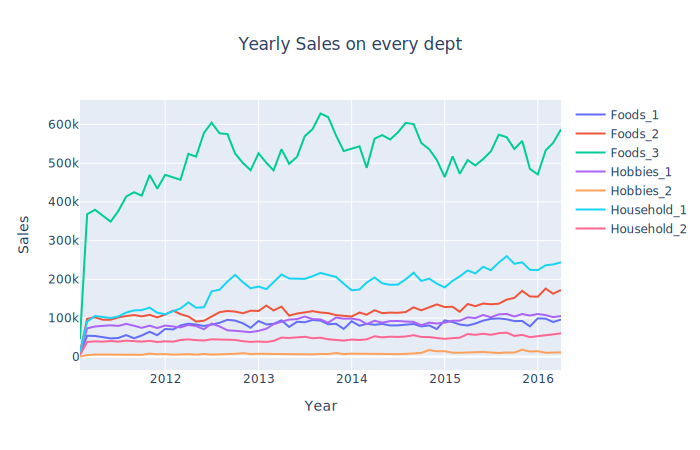

In [14]:
group_plot(cate='dept_id', titl='Yearly Sales on every dept',x_axis='Year', y_axis='Sales')

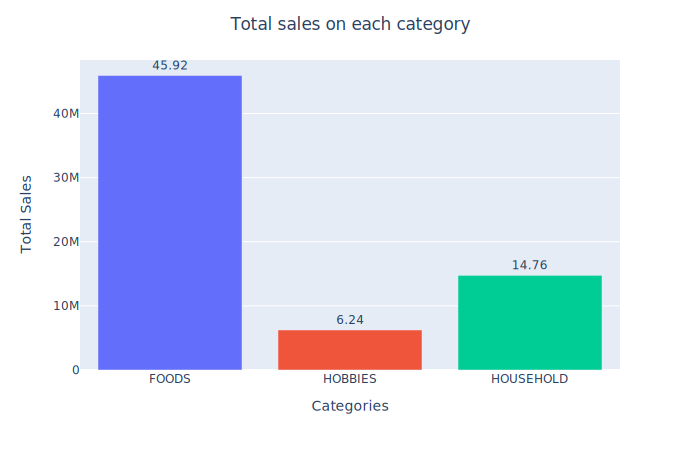

In [15]:
# We are grouping all the items by it's categories and first summing it upto daily value and again summing it up to get total sale value of each category.
temp1 = sales.groupby('cat_id')[days].sum().sum(axis=1)

# Then we are creating a dataframe for creating a bar plot.
temp1=pd.DataFrame({'cat':temp1.index,"vals":temp1.values})

#Creating a bar plot by defining the x values, y values, color, labels here means the name for X-and Y-axis, text displays the values above every bar.
fig = px.bar(x=temp1['cat'], y=temp1['vals'], color=['red','green','blue'], labels={'x':'Categories','y':'Total Sales'}, text=np.round(temp1['vals']/10**6,2))

# Defining what to be displayed when we hover over the bars by the parameter and textposition = outside defines the values we defined in text on px.bar will be displayed 
# outside the bar.
fig.update_traces(hovertemplate='Categories: %{x} <br>Total Sales: %{y}', textposition='outside')

# Legends are turned off as it's a bar plot and we definig the size of the chart.
fig.update_layout(showlegend=False, title="Total sales on each category", title_x=0.5, width=550,height=500)
fig.show()

**Observation:**
* Food sales range the highest above 40M followed by Household items around 15M and lastly Hobbies.
* Food_2 caegories are sold the most, and then household_1.
* The least sold item is Hobbies_2.
* As food is an important aspect the sales are huge on Food products.

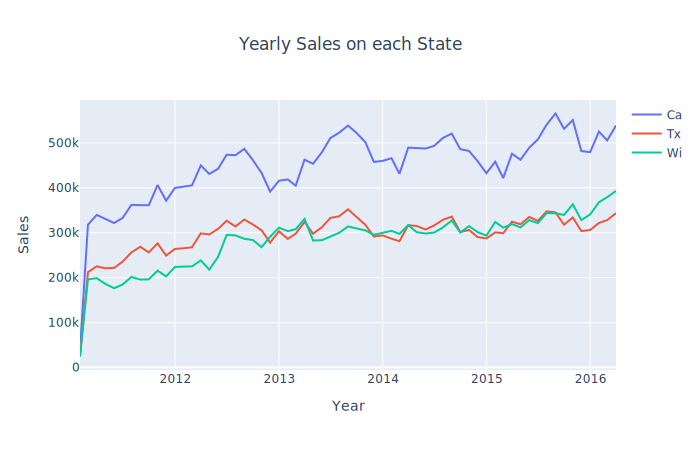

In [16]:
group_plot(cate='state_id', titl='Yearly Sales on each State', x_axis='Year', y_axis= "Sales")

**Observation:**
* The sales on Wisconsin and Texas are almost overlapping each other from 2013.
* Sales on California tops the chart, this could be because of the increased population on comparison to the others.
* Although the population of Wisconsin is lot less than Texas and Texas has slighlty more GDP than Wisconsin, the difference between these two states is marginal.

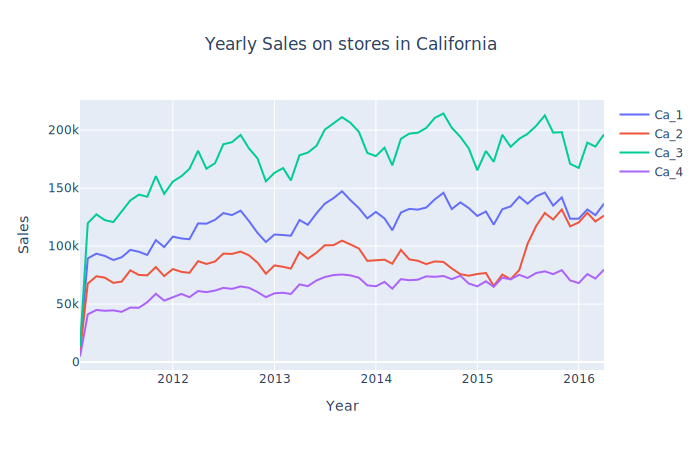

In [17]:
group_plot(cate='store_id', titl='Yearly Sales on stores in California', x_axis='Year', y_axis= "Sales", to=4)

**Observation:**
* Although California was leading on market sales, we can see the sales within California on different stores are very diverse.
* Store 2 in California has caught up with store 1 from June 2015. There has a peak on sales for 4 months since then and has kept the sale rate constant with respect to seasonal changes.
* Sales in store 4 has been increasing gradually every year.

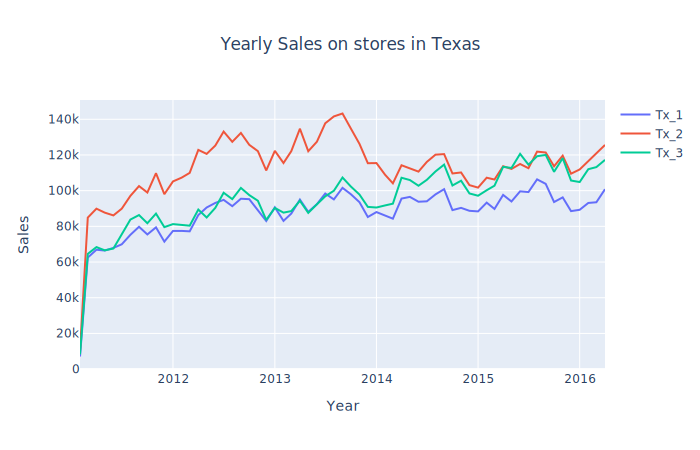

In [18]:
group_plot(cate='store_id', titl='Yearly Sales on stores in Texas', x_axis='Year', y_axis= "Sales", from_=4, to=7)

**Observation:**
* The sales happened on Store 2 during the 2012 to 2014 was huge than the other stores, but then it has gradually falled and then tried to keep it constant on par with the other stores.

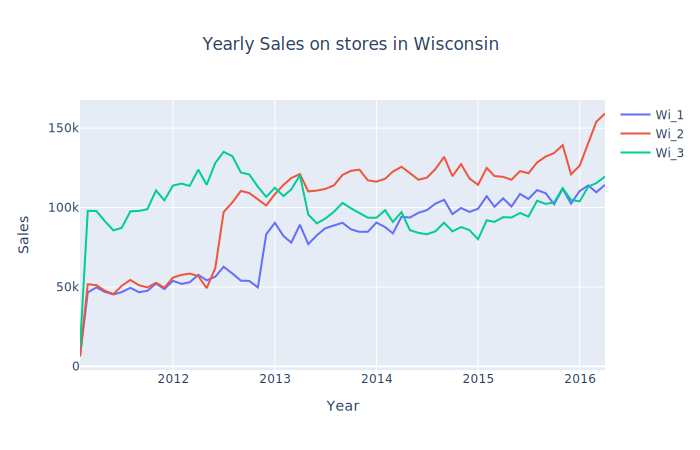

In [19]:
group_plot(cate='store_id', titl='Yearly Sales on stores in Wisconsin', x_axis='Year', y_axis= "Sales", from_=7)

**Observation:**
* Store 3 had a great sales July 2012, and then there has been a great fall.
* That was the same time when Store 2 had a great surge in sale. This could possibly becasue there has been some internal changes on Store 2.
* Store 1 had almost overlapping sales with Store 2 before it had a surge, then store 1 had a growth in sales and had on par sales with Store 3.

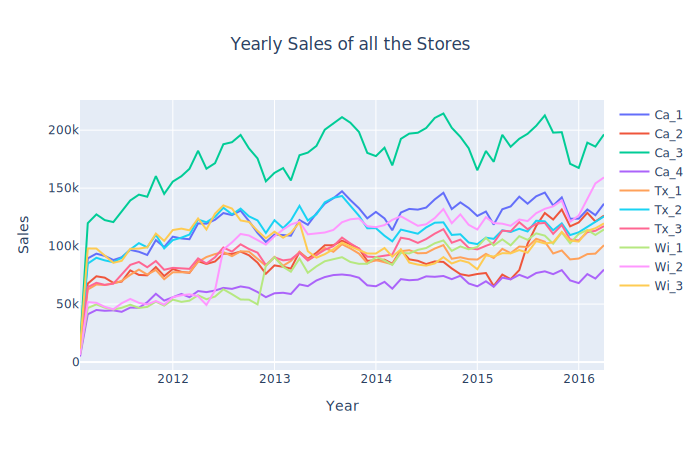

In [20]:
group_plot(cate='store_id', titl='Yearly Sales of all the Stores', x_axis='Year', y_axis= "Sales")

**Observation:**
* We previoulsy observed that California had the most sales than Texas and Wisconsin, but itseems Store 3 in California ranks first for most sales also Store in California ranks last for the least number of sales.
* The sales on Store 1 in California differs from sales on other stores in all States by a great margin.

# **Sell Prices - EDA**

In [21]:
"""We are reading the CSV file and printing the top 2 rows"""

sell_price = pd.read_csv("sell_prices.csv")
sell_price.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [22]:
print(f" There are {sell_price.isna().sum().sum()} missing/NaN values in sell_price dataframe")

 There are 0 missing/NaN values in sell_price dataframe


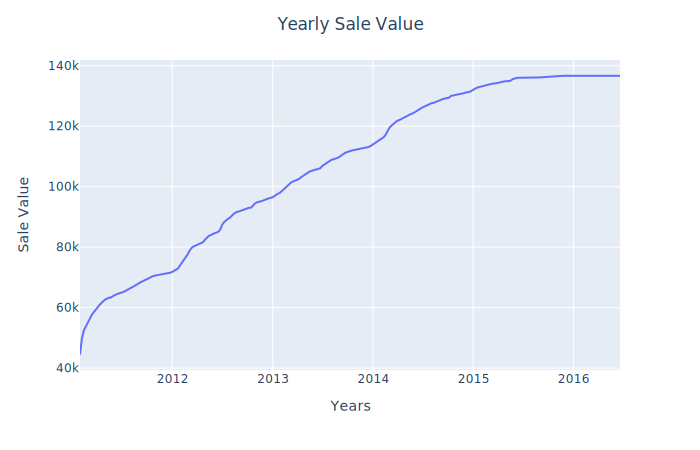

In [23]:
# We are creating a varibale with dates between two period and it's weekly for the X-axis in plot
a = pd.date_range(start='2011-01-29', end="2016-06-19", freq='W')

# We are grouping the sale value for every week and summing it.
temp = sell_price.groupby('wm_yr_wk').sum().reset_index()

# We are then plotting the line chart  with weekly dates as x axis and accumulated price every week to be on y axis.
fig = px.line(x = a, y = temp['sell_price'])

fig.update_layout(title='Yearly Sale Value', xaxis_title='Years',yaxis_title='Sale Value', title_x=0.5)
fig.show()

**Observation:**
* The total sales cost has increased every year till 2015. 
* After 2015, the sales has almost been constant with no ups or downs.

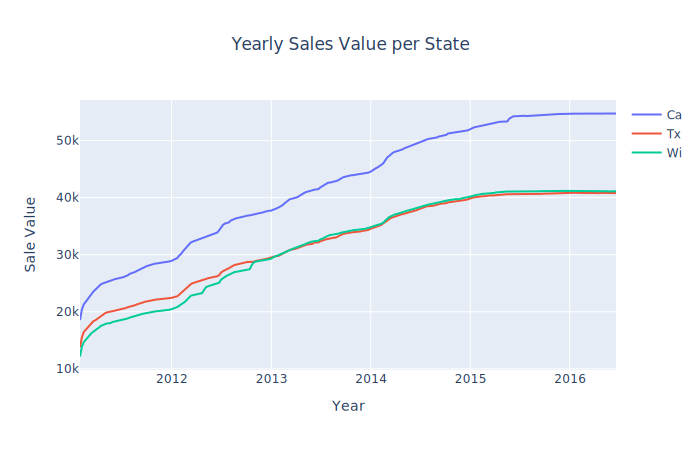

In [24]:
sell_price['state'] = list(map(lambda x:x[:2], sell_price['store_id']))

# We are grouping the sale value by every week and by it's state then summing it.
temp = sell_price.groupby(['wm_yr_wk','state']).sum().unstack()

# Multiple layers of column names are created, hence we are dropping the coulmns at level 0.
temp.columns = temp.columns.droplevel()

# We are creating a variable fig to display the plotly chart
fig = go.Figure()

# Then for every feature in the dataframe, we are creating a line plot and then appending it to the variable fig
for i in temp.columns:
    fig.add_trace(go.Scatter(x = a, y = temp[i], name=str(i).title()))

fig.update_layout(title='Yearly Sales Value per State', xaxis_title='Year',yaxis_title='Sale Value', width=900, height=500,title_x=0.5)

**Observation:**
* California tops the sales every year, whereas sales in Texas and Wisconsin are almost the same
* We can understand that same type of prodcts are being sold almost equally across all the states as the total sale price graph is sames as the number products sold on each state.

# **Calendar - EDA**

In [25]:
# Reading the cal and sales csv file and displaying the top 2 rows from cal file

cal = pd.read_csv("calendar.csv")
sales = pd.read_csv("sales_train_evaluation.csv")
cal.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [26]:
print(f"There are totally {cal.event_type_1.nunique()} {tuple(cal.event_type_1.unique()[1:])} types of events happening through out the year")
print(f"There are {cal.isna().sum().sum()} missing/NaN values in cal dataframe")

There are totally 4 ('Sporting', 'Cultural', 'National', 'Religious') types of events happening through out the year
There are 7542 missing/NaN values in cal dataframe


In [27]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


**Observation:**
    
> On the span of 5 years between 2011-01-29 and 2016-06-19, there were special events on 162 days out of which 5 days had multiple events.


In [28]:
# Filling the places of NaN values with No_Event
cal.fillna('No_Event', inplace=True)

# Days contains the column names from d_1 to d_1941, we are picking only those columns from the sales csv
c = sales[days].T

# we are picking the features weekday and d from the cal csv till 1941 rows.
d = cal[['weekday','d']][:1942]

In [29]:
"""We are merging the dataframe c and d and setting the index to be d and grouping it by weekdays and summing it which gives the sale of every product each, 
we are again summing it up, this gives the sale of total products on a weekday and then sorting by it's increasing order."""

temp = c.merge(d,left_index=True, right_on='d')
temp.set_index('d', inplace=True)
temp = temp.groupby('weekday').sum().sum(axis=1).sort_values()
y = [str(np.round(i/temp.sum()*100, 2))+'%' for i in temp.values]

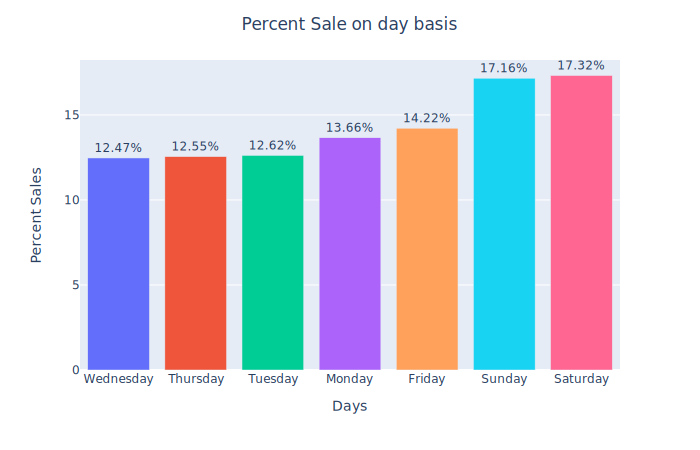

In [30]:
"""We are defining a variable colors for different colours, then plotting a bar graph"""

colors = ['a','b','c','d','e','f','g']
fig = px.bar(x=temp.index, y=y, labels={'x':"Days","y":'Percent Sales'},color=colors, text=y)
fig.update_traces(hovertemplate='Total Sales: %{y}', textposition='outside')
fig.update_layout(showlegend=False, title="Percent Sale on day basis", title_x=0.5,width=800, height=500)
fig.show()

**Observation:**
* There's a huge number of sales happening during the weekends.
* The sales rise and fall before and after weekends from Friday to Monday.

In [31]:
# https://stackoverflow.com/a/53844958

# We are picking only the days column from sales csv, transposing it then summing it up, such that now total sales on a day is produced.
c = sales[days].T.sum(axis=1)
# We are then converting it into a DataFrame, so that we can merge it with other DataFrames later
c = pd.DataFrame(c)

# we are picking the features weekday and d from the cal csv till 1941 rows.
d = cal[['weekday','d']][:1942]

# We are then merging both c and d for our analysis and dropping d column, as it was required only for merging.
temp = c.merge(d,left_index=True, right_on='d')
temp.drop('d',axis=1, inplace=True)

# We are grouping all sales dara together to it sale day.
cole = {}
for i,j in zip(temp[0],temp['weekday']):
    if j not in cole:
        cole[j] = []
    else:
        cole[j].append(i)

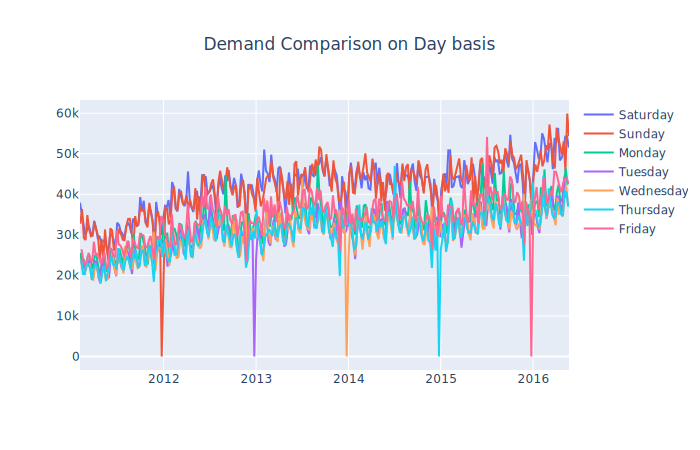

In [32]:
fig = go.Figure()

# Then for every feature in the dataframe, we are creating a line plot and then appending it to the variable fig

for i in cole.keys():
    # Generating dates between two period on weekly basis and the date starts depeding on the day we need.
    a = pd.date_range(start='2011-02-05', end="2016-06-19", freq ='W-'+str(i)[:3])
    fig.add_trace(go.Scatter(x = a, y = cole[i], name=str(i).title()))

fig.update_layout(height=600, hovermode='x', title='Demand Comparison on Day basis', title_x=0.5)

fig.show()

**Observation:**
* The demand line on Saturday and Sunday kinda overlap with each other but not completely.
* Every Year on Last Monday of August, there's a sales peak.

In [33]:
"""We are picking the features event_type_1 and d from the cal csv then merging it with c and setting the index to be d and grouping it by event_type_1 
and taking a mean of it which gives the avg. sale of every product, we are again taking mean, this gives the avg. sale of total products on a weekday 
and then sorting by it's increasing order. We are taking average here because the days with no events are very high than days with events, hence summing 
those values will be improper."""

d = cal[['event_type_1','d']]
temp = c.merge(d,left_index=True, right_on='d')
temp.set_index('d', inplace=True)
temp = temp.groupby('event_type_1').mean().mean(axis=1).sort_values()
y = [str(np.round(i/temp.sum()*100, 2))+'%' for i in temp.values]

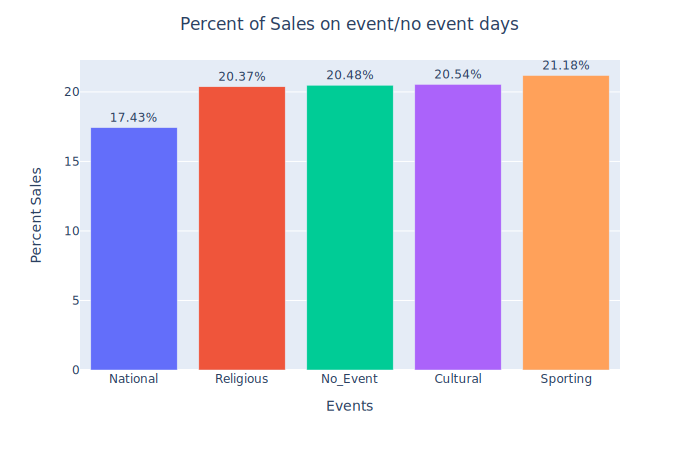

In [34]:
colors = ['a','b','c','d','e']
fig = px.bar(x=temp.index, y=y, labels={'x':"Events","y":'Percent Sales'},color=colors, text=y)
fig.update_traces(hovertemplate='Total Sales: %{y}', textposition='outside')
fig.update_layout(showlegend=False, title="Percent of Sales on event/no event days", title_x=0.5, width=800, height=500)
fig.show()

**Observation:**
* The sales happened during sporting event times are slightly more than sales happened around no events and other events.
* The sales happened on National event days are little lower, but we can conlude it's the cause of low sales.

In [35]:
"""We are creating a new feature No. of events in cal csv, by counting how many time 'No_Event' comes in a row.
If there are 4 No_Events in a row it means there were no events on that day, if there was 2 "No Events" on a row then it means there was 1 event on that day
and if there 0 "No_Events" on a row, then it means there were 2 events on that day."""

g = []
for i in np.sum(cal == 'No_Event', axis=1):
    if i == 0:
        g.append('Two')
    elif i == 2:
        g.append('One')
    else:
        g.append('Zero')

cal['No_of_events'] = g

In [36]:
"""Now just the previous cells we are grouping them, calculating the mean and then plotting them"""

d = cal[['No_of_events','d']]
temp = c.merge(d,left_index=True, right_on='d')
temp.set_index('d', inplace=True)
temp = temp.groupby('No_of_events').mean().mean(axis=1).sort_values()
y = [str(np.round(i/temp.sum()*100, 2))+'%' for i in temp.values]

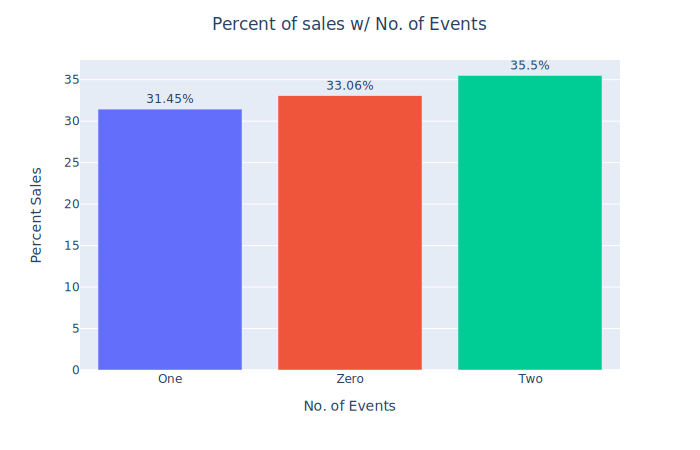

In [37]:
colors = ['a','b','c']
fig = px.bar(x=temp.index, y=y, labels={'x':"No. of Events","y":'Percent Sales'},color=colors, text=y)
fig.update_traces(hovertemplate='Total Sales: %{y}', textposition='outside')
fig.update_layout(showlegend=False, title="Percent of sales w/ No. of Events", title_x=0.5, width=800, height=500)
fig.show()

**Observation:**
* When there were 2 events on a day the sales happened are little high than days when there were no events.
* But on the contrary, when there were 1 event, the sales happened were little less than days when there were no events.

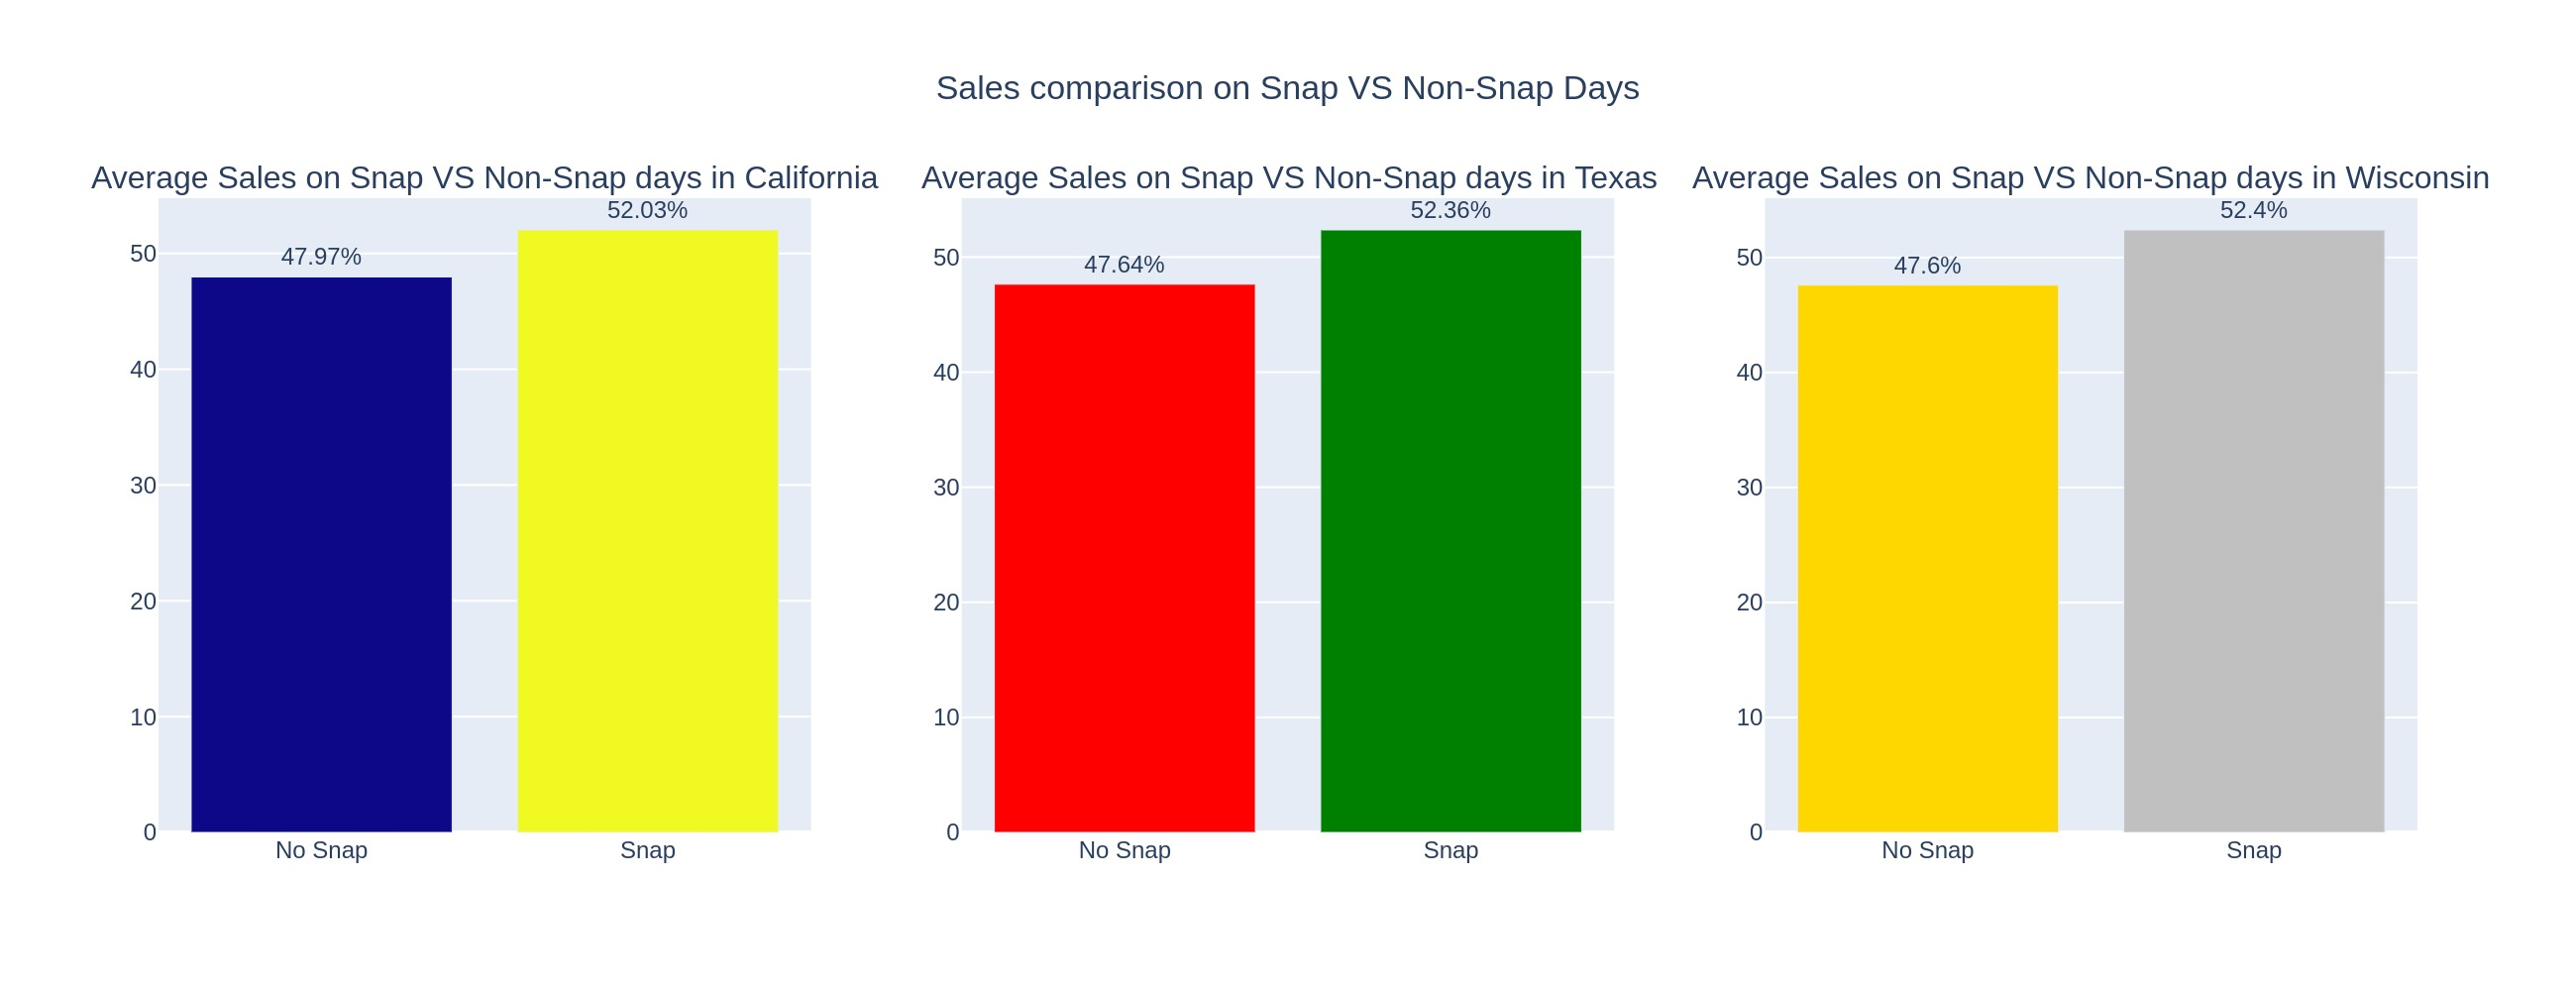

In [38]:
# https://plotly.com/python/static-image-export/
# https://stackoverflow.com/a/28238656

# We are picking only the snap features from the cal csv and d for merging with sales csv
d = cal[['snap_CA','snap_TX','snap_WI','d']]
temp = c.merge(d,left_index=True, right_on='d')
temp.set_index('d', inplace=True)

# We are then replacing 0s and 1s with No snap and Snap on all the 3 snap columns.
temp['snap_CA'] = temp['snap_CA'].apply(lambda x: "No Snap" if x==0 else "Snap")
temp['snap_TX'] = temp['snap_TX'].apply(lambda x: "No Snap" if x==0 else "Snap")
temp['snap_WI'] = temp['snap_WI'].apply(lambda x: "No Snap" if x==0 else "Snap")

# We are then creating a subplot with 1 row and 3 columns, and giving a title for each subplot.
fig = make_subplots(rows=1, cols=3, subplot_titles=('Average Sales on Snap VS Non-Snap days in California', \
                                                    'Average Sales on Snap VS Non-Snap days in Texas', \
                                                    'Average Sales on Snap VS Non-Snap days in Wisconsin'))

"""We are then grouping with snap feature for every state and taking it's mean to give avg. sale of every product for snap and no snap days, 
hence taking mean again to get the avg. sales on total during the snap and non-snap days. Then from the mean value we are computing it's percent of sales.
Then we are creating a bar plot and adding it to the fig for all the states."""

temp1 = temp.groupby('snap_CA').mean().mean(axis=1).sort_values()
y = [str(np.round(i/temp1.sum()*100, 2))+'%' for i in temp1.values]

# We are passing name parameter with empty string to remove hover which says the trance number.
fig.add_trace(go.Bar(x=temp1.index, y=y, text=y, name = "", marker=dict(color=[1,2])))

temp1 = temp.groupby('snap_TX').mean().mean(axis=1).sort_values()
y = [str(np.round(i/temp1.sum()*100, 2))+'%' for i in temp1.values]

fig.add_trace(go.Bar(x=temp1.index, y=y, text=y, name = "", marker=dict(color=['red', 'green'])), 1,2)

temp1 = temp.groupby('snap_WI').mean().mean(axis=1).sort_values()
y = [str(np.round(i/temp1.sum()*100, 2))+'%' for i in temp1.values]

fig.add_trace(go.Bar(x=temp1.index, y=y, text=y, name = "", marker=dict(color=['gold','silver'])),1,3)

fig.update_traces(hovertemplate='Total Sales: %{y}',textposition='outside')
fig.update_layout(showlegend=False, title_text="Sales comparison on Snap VS Non-Snap Days", title_x=0.5, width =1300)
if pio.renderers.default == 'colab' or pio.renderers.default == 'notebook_connected':
    fig.show()
else:
    img_bytes = fig.to_image(format="jpeg", width=1300, height=500, scale=2)
    img = Image(img_bytes)
    display(img)

 **Observation:**
* Clearly the sales on all the states during the Snap days are high than Non-Snap days, but the difference is not bit.
* All the states have almost same amount of sales when on Snap or Non-Snap days.

In [39]:
# We are generating month names based on the date provided
cal['Month'] = pd.to_datetime(cal['date']).dt.strftime('%B')

# We are picking only the days column from sales csv, transposing it then summing it up, such that now total sales on a day is produced.
c = sales[days].T.sum(axis=1)
# We are then converting it into a DataFrame, so that we can merge it with other DataFrames later
c = pd.DataFrame(c)

# we are picking the features Month,d and year from the cal csv till 1941 rows.
d = cal[['Month','d','year']][:1942]

# We are then merging both c and d for our analysis
temp = c.merge(d,left_index=True, right_on='d')

# Now before summing up the sales on every month we are grouping those with their year and month and then summing it up.
temp = temp.groupby(['year','Month']).sum().unstack()

# As we have multiple levels of columns, we are dropping column names at level 1
temp.columns = temp.columns.droplevel(level=0)

# We are then generating date between 2 periods on Yearly start dates.
a = pd.date_range(start='2011-01', end="2016-06", freq = 'YS')

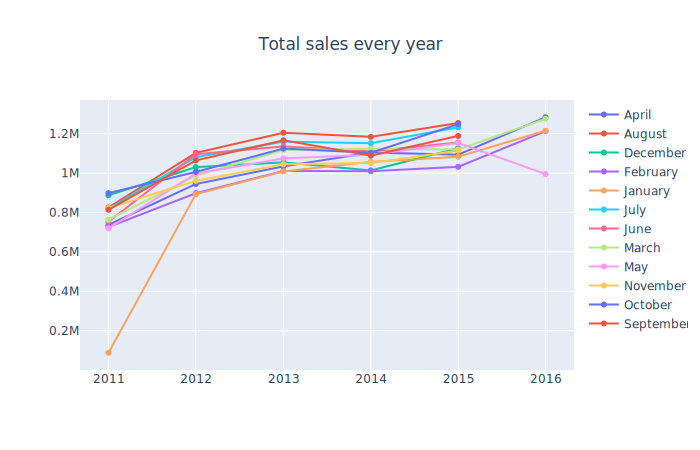

In [40]:
fig = go.Figure()

# Then for every feature in the dataframe, we are creating a line plot and then appending it to the variable fig
for i in temp.columns:
    fig.add_trace(go.Scatter(x = a, y = temp[i], name=str(i).title()))

fig.update_layout(height=600, hovermode="x", title='Total sales every year', title_x=0.5)

fig.show()

Observation:
* Since 2012, August rates the highest sales about 1.2M products
* July either ranks 2nd or 3rd on total sales.
* At 2016, the sales numbers have increased almost 20%.